<a href="https://colab.research.google.com/github/waveology/kitchen/blob/main/02_introduccion_cdo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<html><img src="https://owncloud.aemet.es/index.php/s/lwiFbCGBRAJHlF7/download?path=%2F&files=logo.png"></html>


* **Autor:** Ernesto Barrera
* **Institución:** AEMET
---

# Introducción a **cdo** (Climate Data Operators)


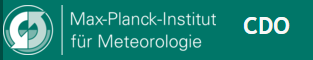

* [Web del proyecto](https://code.mpimet.mpg.de/projects/cdo/wiki/Cdo#Documentation)
* [Guía de usuario](https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf)

* **¿Qué es CDO?** Un conjunto (extenso) de operadores que actúan sobre ficheros en formato NetCDF o GRIB.

* **¿Cómo se usa CDO?** Se invocan en línea de comandos aunque existe una interfaz Python.

* **¿Cuándo usar CDO?** Cuando se requiera el
preproceso eficiente en memoria, especialmente con datos masivos.

* **¿Por qué CDO?** Porque funciona tanto con datos GRIB como con NetCDF





* **Uso simple**:

> `$ cdo [operador]   fichero_entrada   fichero_salida`

* **[Uso encadenado](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-200001.2.6)**:

> `$ cdo -[operador1] fichero_entrada1 -[operador2] fichero_entrada2 [...] fichero_salida`

* **Paralelización OMP ([solo algunos operadores](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-958000B))**:

> `$ cdo -P 12 -operador_paralelizado fichero_entrada fichero_salida`


**Organización de los operadores por tipo de acción:**
>* Información
* Partición/fusión de ficheros
* Selección
* Comparación
* Modificación
* Aritmética
* Estadística
* Correlación
* Regresión
* Componentes principales
* Interpolación
* Transformación
* Entradas y salidas
* Miscelánea


## Instalación desde condacolab
---

In [ ]:
# Instala conda en Colab
# Este proceso implica un reinicio del kernel y
# es normal que aparezca un mensaje de fallo en la sesión
# --------------------------------------------------------
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# Verifica la instalación
# ------------------------
import condacolab
condacolab.check()


In [ ]:
# Instala cdo
# ----------------------
!mamba install -q cdo

##Descarga de datos
---

Descargamos ficheros de datos del reanálisis ERA/ECMWF para experimentar

In [ ]:
ifile = 'era5_t2m_w10_2020_europa_025.rar'
!wget -q --no-check-certificate https://owncloud.aemet.es/index.php/s/7tJ8c3UpRK9sqVE/download -O {ifile} && unrar -o+ e {ifile} && rm -f {ifile}
!mv era5_t2m_w10_2020_europa_025.nc era5_2000.nc

ifile = 'era5_t2m_1987_2020_europa_025_lsm.rar'
!wget -q --no-check-certificate https://owncloud.aemet.es/index.php/s/leirUBqlMnLxIAL/download -O {ifile} && unrar -o+ e {ifile} && rm -f {ifile}
!mv era5_t2m_1987_2020_europa_025_lsm.nc mascara_tierra_mar.nc

## Operadores de [información](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-560002.1)
---

Permiten obtener metadatos de los ficheros (variables, coordenadas, tiempos, etc)

In [4]:
# Información y estadística básica
# ---------------------------------
!cdo    info    era5_2000.nc | head -n 10

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter ID
     1 : 2020-01-01 12:00:00       0    25921       0 :     -11.517    -0.51731      14.942 : -1            
     2 : 2020-01-01 12:00:00       0    25921       0 :     -13.074      4.1927      23.707 : -2            
     3 : 2020-01-01 12:00:00       0    25921       0 :      262.38      285.93      295.21 : -3            
     4 : 2020-01-02 12:00:00       0    25921       0 :     -11.230      1.2525      19.340 : -1            
     5 : 2020-01-02 12:00:00       0    25921       0 :     -17.157      1.2410      16.085 : -2            
     6 : 2020-01-02 12:00:00       0    25921       0 :      260.46      285.69      296.55 : -3            
     7 : 2020-01-03 12:00:00       0    25921       0 :     -11.227    0.020584      18.799 : -1            
     8 : 2020-01-03 12:00:00       0    25921       0 :     -11.802      1.2643      15.555 : -2            
     9 : 2020-01-03 1

In [5]:
# Información reducida
# ---------------------------------
!cdo    sinfo   era5_2000.nc | head -n 20

   File format : NetCDF2
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  v instant       1   1     25921   1  I16  : -1            
     2 : unknown  unknown  v instant       1   1     25921   1  I16  : -2            
     3 : unknown  unknown  v instant       1   1     25921   1  I16  : -3            
   Grid coordinates :
     1 : lonlat                   : points=25921 (161x161)
                        longitude : -30 to 10 by 0.25 degrees_east
                         latitude : 60 to 20 by -0.25 degrees_north
   Vertical coordinates :
     1 : surface                  : levels=1
   Time coordinate :
                             time : 366 steps
     RefTime =  1900-01-01 00:00:00  Units = hours  Calendar = gregorian
  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss
  2020-01-01 12:00:00  2020-01-02 12:00:00  2020-01-03 12:00:00  2020-01-04 12:00:00
  2020-01-05 12:00:00  2020-01-06 12

In [6]:
# Nombre de las variables
# -----------------------
!cdo    showname    era5_2000.nc

 u10 v10 t2m
cdo    showname: Processed 3 variables [0.01s 94MB]


In [7]:
# Número de parámetros
# ---------------------------------
!cdo    npar    era5_2000.nc

3
cdo    npar: Processed 3 variables [0.01s 94MB]


In [8]:
# Número de niveles
# ---------------------------------
!cdo nlevel era5_2000.nc

1
1
1
cdo    nlevel: Processed 3 variables [0.01s 95MB]


In [9]:
# Número de fechas
# ---------------------------------
!cdo ndate era5_2000.nc

366
cdo    ndate: Processed 3 variables over 366 timesteps [0.01s 95MB]


In [10]:
# Número de puntos de rejilla de cada variable
# --------------------------------------------
!cdo ngridpoints era5_2000.nc

25921
25921
25921
cdo    ngridpoints: Processed 3 variables [0.01s 95MB]


In [11]:
# Formato del fichero
# --------------------
!cdo showformat era5_2000.nc

NetCDF2
cdo    showformat: Processed 3 variables [0.01s 95MB]


In [12]:
# Atributos NetCDF locales y globales
# ----------------.........----------
!cdo showatts era5_2000.nc

u10:
   long_name = "10 metre U wind component"
   units = "m s**-1"
   missing_value = -32767
   add_offset = 3.3796
   scale_factor = 0.000744071
v10:
   long_name = "10 metre V wind component"
   units = "m s**-1"
   missing_value = -32767
   add_offset = 0.859812
   scale_factor = 0.000729501
t2m:
   long_name = "2 metre temperature"
   units = "K"
   missing_value = -32767
   add_offset = 289.974
   scale_factor = 0.000981111
Global:
   Conventions = "CF-1.6"
   history = "2023-06-19 09:03:51 GMT by grib_to_netcdf-2.30.2: grib_to_netcdf era5_t2m_w10_2020_europa_025 -o era5_t2m_w10_2020_europa_025.nc"
cdo    showatts: Processed 3 variables [0.02s 95MB]


## [Operadores de ficheros](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-920002.2)
---

###Separación
Entre los más usados están aquellos que permiten trocear o fusionar los ficheros en base a algun criterio (variables, tiempo, etc).

Los operadores con prefijo 'split' se usan para separar:

In [13]:
# Separa un fichero de datos anuales en 12 ficheros
# con datos mensuales
# ---------------------------------------------------
!cdo    splitmon    era5_2000.nc    mes_

cdo    splitmon: Processed 28461258 values from 3 variables over 366 timesteps [0.53s 95MB]


In [14]:
# Muestra las fechas contenidas en el fichero correspondiente
# al mes de febrero
# ------------------------------------------------------------
!cdo    showdate    mes_02.nc

  2020-02-01  2020-02-02  2020-02-03  2020-02-04  2020-02-05  2020-02-06  2020-02-07  2020-02-08  2020-02-09  2020-02-10  2020-02-11  2020-02-12
  2020-02-13  2020-02-14  2020-02-15  2020-02-16  2020-02-17  2020-02-18  2020-02-19  2020-02-20  2020-02-21  2020-02-22  2020-02-23  2020-02-24
  2020-02-25  2020-02-26  2020-02-27  2020-02-28  2020-02-29
cdo    showdate: Processed 6 variables over 29 timesteps [0.01s 95MB]


In [15]:
# Separa el fichero de datos de febrero en uno por cada variable
# ---------------------------------------------------------------
!cdo    splitvar    mes_02.nc    febrero_

cdo    splitname: Processed 2255127 values from 3 variables over 29 timesteps [0.05s 95MB]


###Fusion
La operación inversa de aglutinar información de múltiples ficheros en uno se lleva a cabo con los operadores de prefijo *merge*

In [16]:
# Separa el fichero de datos de febrero en uno por cada variable
# ---------------------------------------------------------------
!cdo    mergetime    mes_12.nc    mes_01.nc    mes_02.nc    DJF.nc

cdo    mergetime: Processed 7076433 values from 9 variables over 91 timesteps [0.15s 95MB]


In [17]:
# Muestra las fechas contenidas en el fichero correspondiente
# al mes de febrero
# ------------------------------------------------------------
!cdo showdate DJF.nc

  2020-01-01  2020-01-02  2020-01-03  2020-01-04  2020-01-05  2020-01-06  2020-01-07  2020-01-08  2020-01-09  2020-01-10  2020-01-11  2020-01-12
  2020-01-13  2020-01-14  2020-01-15  2020-01-16  2020-01-17  2020-01-18  2020-01-19  2020-01-20  2020-01-21  2020-01-22  2020-01-23  2020-01-24
  2020-01-25  2020-01-26  2020-01-27  2020-01-28  2020-01-29  2020-01-30  2020-01-31  2020-02-01  2020-02-02  2020-02-03  2020-02-04  2020-02-05
  2020-02-06  2020-02-07  2020-02-08  2020-02-09  2020-02-10  2020-02-11  2020-02-12  2020-02-13  2020-02-14  2020-02-15  2020-02-16  2020-02-17
  2020-02-18  2020-02-19  2020-02-20  2020-02-21  2020-02-22  2020-02-23  2020-02-24  2020-02-25  2020-02-26  2020-02-27  2020-02-28  2020-02-29
  2020-12-01  2020-12-02  2020-12-03  2020-12-04  2020-12-05  2020-12-06  2020-12-07  2020-12-08  2020-12-09  2020-12-10  2020-12-11  2020-12-12
  2020-12-13  2020-12-14  2020-12-15  2020-12-16  2020-12-17  2020-12-18  2020-12-19  2020-12-20  2020-12-21  2020-12-22  2020-12-

En muchos casos, los operadores pueden encadenarse anteponiendo un guión a su nombre. Esto optimiza los procesos porque evitan la creación de ficheros intermedios y la escritura a disco es a menudo un cuello de botella en el cálculo intensivo.

In [18]:
# Encadenado de operadores
# 1) se fusionan los datos correspondientes a los meses de verano
# 2) la fusión resultante se separa en un fichero por cada variable
# ----------------------------------------------------------------------
!cdo  -splitvar    -mergetime    mes_06.nc    mes_07.nc    mes_08.nc    JJA_


# Es lo mismo que esto
# ----------------------
# !cdo    mergetime    mes_06.nc    mes_07.nc    mes_08.nc  fichero_de_paso.nc
# !cdo    splitvar    fichero_de_paso.nc  JJA_

cdo(1) mergetime: Process started
cdo(1) mergetime: Processed 7154196 values from 9 variables over 92 timesteps
cdo    splitname: Processed 7154196 values from 3 variables over 92 timesteps [0.19s 95MB]


In [19]:
# Limpieza
# ----------------------------------
!rm -f mes_*.nc febrero_*.nc JJA_*.nc

##Operadores de [selección](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-1670002.3)
---

Permiten elegir el contenido de un fichero en base a diversos criterios

###Ejemplo: selección de datos estacionales

In [20]:
# Selecciona los datos correspondientes a la temperatura del invierno climatológico
# ----------------------------------------------------------------------------------
!cdo    select,name=t2m,season=DJF    era5_2000.nc    DJF_t2m.nc

cdo    select: Processed 2358811 values from 3 variables over 366 timesteps [0.05s 95MB]


In [21]:
# Elimina los días 29 de febrero que encuentre en
# el fichero de entrada (dom = day of month)
# -------------------------------------------------------
!cdo    delete,dom=29feb    DJF_t2m.nc    DJF_t2m_sin_29feb.nc

cdo    delete: Processed 2332890 values from 1 variable over 91 timesteps [0.05s 95MB]


In [22]:
# Comprobación
# ------------------------------------------------------------
!cdo showdate DJF_t2m.nc
!cdo showdate DJF_t2m_sin_29feb.nc

  2020-01-01  2020-01-02  2020-01-03  2020-01-04  2020-01-05  2020-01-06  2020-01-07  2020-01-08  2020-01-09  2020-01-10  2020-01-11  2020-01-12
  2020-01-13  2020-01-14  2020-01-15  2020-01-16  2020-01-17  2020-01-18  2020-01-19  2020-01-20  2020-01-21  2020-01-22  2020-01-23  2020-01-24
  2020-01-25  2020-01-26  2020-01-27  2020-01-28  2020-01-29  2020-01-30  2020-01-31  2020-02-01  2020-02-02  2020-02-03  2020-02-04  2020-02-05
  2020-02-06  2020-02-07  2020-02-08  2020-02-09  2020-02-10  2020-02-11  2020-02-12  2020-02-13  2020-02-14  2020-02-15  2020-02-16  2020-02-17
  2020-02-18  2020-02-19  2020-02-20  2020-02-21  2020-02-22  2020-02-23  2020-02-24  2020-02-25  2020-02-26  2020-02-27  2020-02-28  2020-02-29
  2020-12-01  2020-12-02  2020-12-03  2020-12-04  2020-12-05  2020-12-06  2020-12-07  2020-12-08  2020-12-09  2020-12-10  2020-12-11  2020-12-12
  2020-12-13  2020-12-14  2020-12-15  2020-12-16  2020-12-17  2020-12-18  2020-12-19  2020-12-20  2020-12-21  2020-12-22  2020-12-

###Ejemplo: operadores encadenados

Las mismas operaciones pero encadenando los operadores.

* Nótese que en general, el orden de encadenamiento puede afectar a la eficiencia.
* Cuando existe ambigüedad en el ámbito de actuación de los operadores se usan paréntesis para clarificarla.

In [23]:
# Selecciona los datos correspondientes al invierno climatológico y eliminamos el 29 de febrero del resultado
# -O fuerza la sobreescritura de un fichero preexistente
# El resultado de 'select' solo existe en memoria
# ---------------------------------------------------------------------------------------------------------
!cdo -O  -delete,dom=29feb   [ -select,name=t2m,season=DJF   era5_2000.nc ]  DJF_t2m_sin_29feb.nc

cdo(1) select: Process started
cdo(1) select: Processed 2358811 values from 3 variables over 366 timesteps
cdo    delete: Processed 2332890 values from 1 variable over 91 timesteps [0.10s 95MB]


In [24]:
# Selecciona un rango arbitrario de fechas
# -------------------------------------------
!cdo seldate,'2020-07-24T00:00:00','2020-08-15T23:59:59' era5_2000.nc europa.nc

## Se obtiene el mismo resultado usando el operador genérico 'select'
## -------------------------------------------------------------------
# !cdo -O select,startdate='2020-07-24T00:00:00',enddate='2020-08-15T23:59:59' era5_2000.nc europa.nc

cdo    seldate: Processed 1788549 values from 3 variables over 229 timesteps [0.06s 95MB]


###Ejemplo: selección de una ventana geográfica

In [25]:
!cdo sinfo europa.nc | head -n 10

   File format : NetCDF2
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  v instant       1   1     25921   1  I16  : -1            
     2 : unknown  unknown  v instant       1   1     25921   1  I16  : -2            
     3 : unknown  unknown  v instant       1   1     25921   1  I16  : -3            
   Grid coordinates :
     1 : lonlat                   : points=25921 (161x161)
                        longitude : -30 to 10 by 0.25 degrees_east
                         latitude : 60 to 20 by -0.25 degrees_north
   Vertical coordinates :


In [26]:
# Selecciona una ventana geográfica en torno a la península ibérica
# ------------------------------------------------------------------
!cdo sellonlatbox,-12,5,35,45 europa.nc  peninsula.nc

cdo    sellonlatbox: Processed 1788549 values from 3 variables over 23 timesteps [0.03s 95MB]


In [27]:
# Importamos xarray y Matplotlib para inspeccionar gráficamente el contenido de los ficheros
# -------------------------------------------------------------------------------------------
import xarray as xr
import matplotlib.pyplot as plt

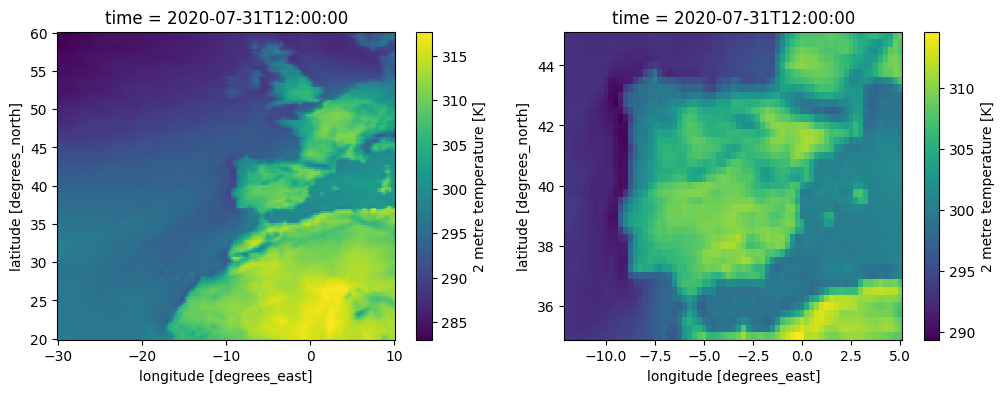

In [28]:
# Dibujamos el fichero original y el resultante de la selección de ventana geográfica
# ------------------------------------------------------------------------------------
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
t1 = xr.open_dataset('europa.nc').t2m.sel(time='20200731').plot(ax=ax1)
t2 = xr.open_dataset('peninsula.nc').t2m.sel(time='20200731').plot(ax=ax2)

###Ejemplo: remuestreo (sin interpolación)

In [29]:
# Remuestreo (no requiere interpolación)
# --------------------------------------------
!cdo samplegrid,4 peninsula.nc remuestreo_4.nc

cdo    samplegrid: Processed 195201 values from 3 variables over 23 timesteps [0.01s 177MB]


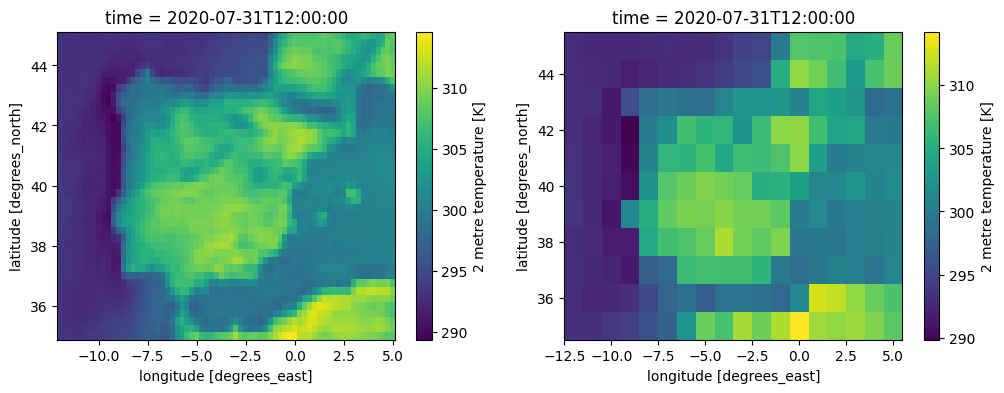

In [30]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
xr.open_dataset('peninsula.nc').t2m.sel(time='20200731').plot(ax=ax1)
xr.open_dataset('remuestreo_4.nc').t2m.sel(time='20200731').plot(ax=ax2)

In [31]:
# Limpieza
# ---------
!rm -f europa_*.nc peninsula_*.nc

##Operadores de [selección condicional](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-2180002.4)
---

Permiten extraer datos de un campo en base a una máscara. Los valores de la máscara pueden ser 0 (falso) o superiores a cero (verdadero).

###Ejemplo: uso de una máscara tierra-mar

In [32]:
# Esta máscara tiene valor 1 en tierra y valor 0 en el mar
# --------------------------------------------------------
!cdo showatts mascara_tierra_mar.nc

lsm:
   standard_name = "land_binary_mask"
   long_name = "Land-sea mask"
   units = "(0 - 1)"
   missing_value = -32767
   add_offset = 0.499992
   scale_factor = 1.52595e-05
Global:
   Conventions = "CF-1.6"
   history = "2023-06-18 18:10:54 GMT by grib_to_netcdf-2.30.2: grib_to_netcdf era5_t2m_1987_2020_europa_025_lsm -o era5_t2m_1987_2020_europa_025_lsm.nc"
cdo    showatts: Processed 1 variable [0.00s 181MB]


In [33]:
# Extraemos la temperatura de un día cualquiera
# ----------------------------------------------
!cdo select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc t.nc

cdo    select: Processed 25921 values from 3 variables over 366 timesteps [0.01s 181MB]


In [34]:
# Aplicamos la máscara para seleccionar solo los valores de temperatura en tierra
# --------------------------------------------------------------------------------
!cdo ifthen   mascara_tierra_mar.nc   t.nc   temperatura_tierra.nc

cdo    ifthen: Processed 51842 values from 2 variables over 2 timesteps [0.01s 181MB]


In [35]:
!cdo showvar temperatura_tierra.nc

 t2m
cdo    showname: Processed 1 variable [0.00s 181MB]


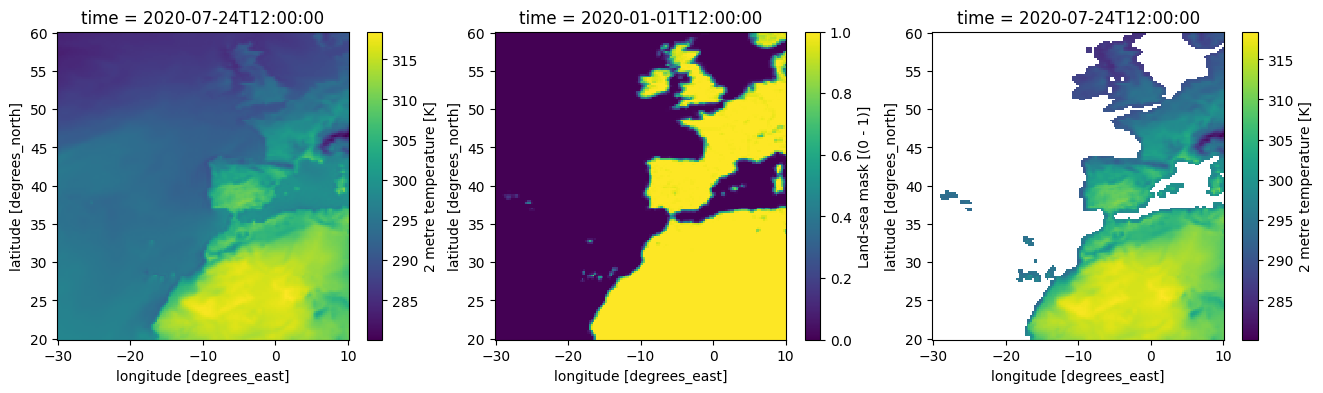

In [36]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('t.nc').t2m.isel(time=0).plot(ax=ax1)
xr.open_dataset('mascara_tierra_mar.nc').lsm.isel(time=0).plot(ax=ax2)
xr.open_dataset('temperatura_tierra.nc').t2m.isel(time=0).plot(ax=ax3)

In [37]:
# Para seleccionar la temperatura en el mar
# Ahora encadenamos los operadores
#------------------------------------------
!cdo -ifnotthen  mascara_tierra_mar.nc -select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc  temperatura_mar.nc

cdo(1) select: Process started
cdo    ifnotthen: Filling up stream1 >mascara_tierra_mar.nc< by copying the first timestep.
cdo(1) select: Processed 25921 values from 3 variables over 366 timesteps
cdo    ifnotthen: Processed 51842 values from 2 variables over 2 timesteps [0.02s 193MB]


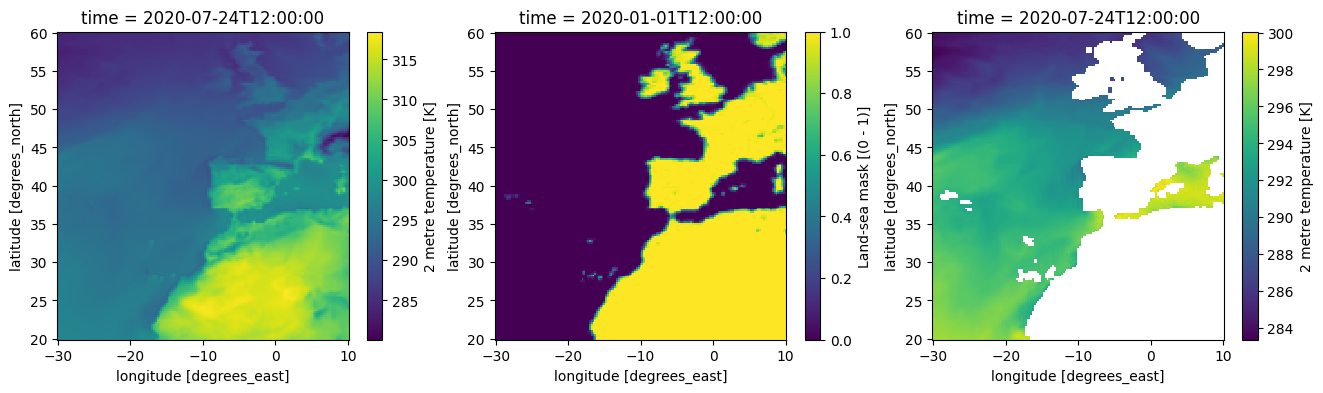

In [38]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('t.nc').t2m.isel(time=0).plot(ax=ax1)
xr.open_dataset('mascara_tierra_mar.nc').lsm.isel(time=0).plot(ax=ax2)
xr.open_dataset('temperatura_mar.nc').t2m.isel(time=0).plot(ax=ax3)

también es posible asignar un valor constante al área enmascarada

In [39]:
# Selección de la temperatura del mar en invierno y la de tierra en verano
#------------------------------------------------------------------------------
!cdo -select,name='t2m',date='2020-06-22T12:00:00' era5_2000.nc t_verano.nc
!cdo -select,name='t2m',date='2020-12-22T12:00:00' era5_2000.nc t_invierno.nc
!cdo -ifthenelse  mascara_tierra_mar.nc t_verano.nc t_invierno.nc hibrido.nc

cdo    select: Processed 25921 values from 3 variables over 366 timesteps [0.01s 202MB]
cdo    select: Processed 25921 values from 3 variables over 366 timesteps [0.01s 202MB]
cdo    ifthenelse: Processed 77763 values from 3 variables over 3 timesteps [0.01s 202MB]


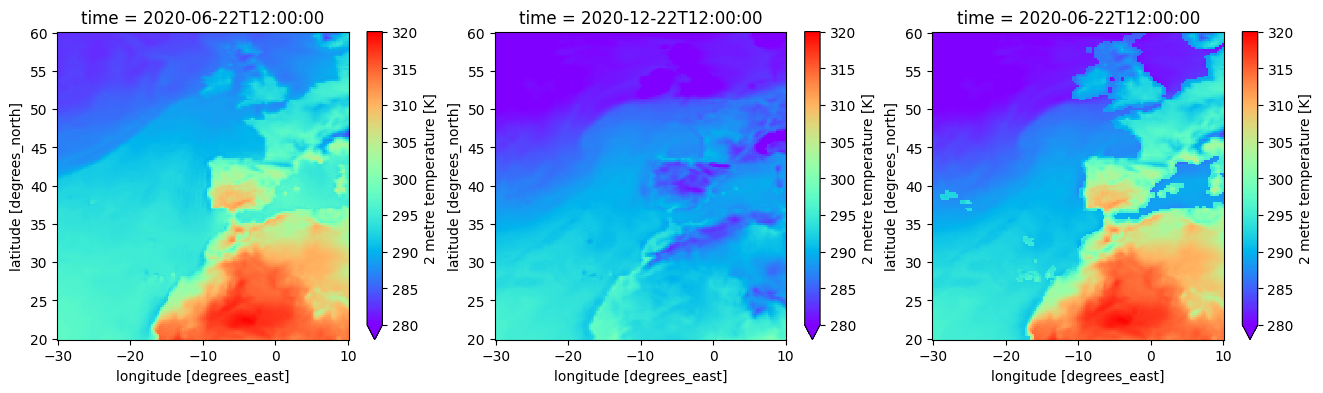

In [40]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('t_verano.nc').t2m.isel(time=0).plot(ax=ax1,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('t_invierno.nc').t2m.isel(time=0).plot(ax=ax2,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('hibrido.nc').t2m.isel(time=0).plot(ax=ax3,cmap='rainbow',vmin=280,vmax=320)

## Operadores de [comparación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-2390002.5)
---

Realizan comparaciones numéricas entre campos y guardan el resultado (ceros y unos) en un nuevo fichero que puede ser usado como máscara en otras operaciones.

###Ejemplo: creación de una máscara

In [41]:
# Selección de datos de temperatura del 1 de julio de 2020
# -----------------------------------------------------------
!cdo -select,name='t2m',date='2020-07-01T12:00:00'  era5_2000.nc julio.nc
# Selección de datos de temperatura del 1 de agosto de 2020
# -----------------------------------------------------------
!cdo -select,name='t2m',date='2020-08-01T12:00:00'  era5_2000.nc agosto.nc

# Creación de una máscara que toma valor 1 si la temperatura en julio supera la de agosto
# La opción -b F32 se asegura de que la comparación se realiza con la precisión necesaria
# ----------------------------------------------------------------------------------------
!cdo -b F32 -gt   julio.nc   agosto.nc   julio_mayor_que_agosto.nc

cdo    select: Processed 25921 values from 3 variables over 366 timesteps [0.01s 212MB]
cdo    select: Processed 25921 values from 3 variables over 366 timesteps [0.01s 212MB]
cdo    gt: Processed 51842 values from 2 variables over 2 timesteps [0.01s 212MB]


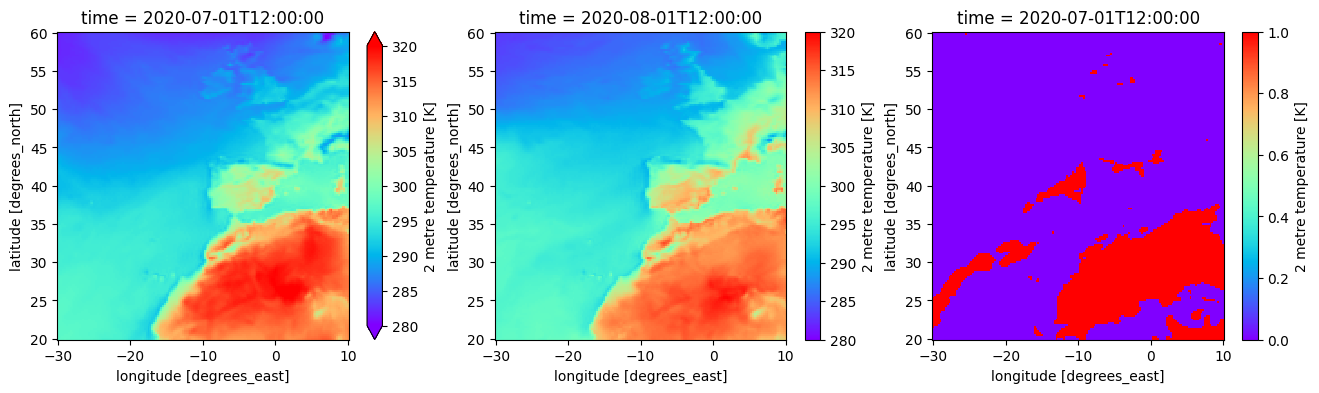

In [42]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))
xr.open_dataset('julio.nc').t2m.isel(time=0).plot(ax=ax1,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('agosto.nc').t2m.isel(time=0).plot(ax=ax2,cmap='rainbow',vmin=280,vmax=320)
xr.open_dataset('julio_mayor_que_agosto.nc').t2m.isel(time=0).plot(ax=ax3,cmap='rainbow',vmin=0,vmax=1)

##Operadores de [modificación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-2510002.6)
---

Realizan cambios en los datos o en los metadatos. Las posibilidades son muy diversas.

###Ejemplo: cambio o adición de atributos NetCDF

In [43]:
# Atributos antes
# ---------------------
!cdo showatts agosto.nc

# Añadimos un atributo local a la variable t2m
# ----------------------------------------------
!cdo setattribute,t2m@nuevo_atributo="propiedad interesante" agosto.nc tmp

# Añadimos un atributo global
# ----------------------------------------------
!cdo setattribute,fiabilidad="Alta" tmp agosto_mod.nc

# Borra el fichero intermedio
# ----------------------------
!rm -f tmp

# Atributos después
# -------------------
!cdo showatts agosto_mod.nc

t2m:
   long_name = "2 metre temperature"
   units = "K"
   missing_value = -32767
   add_offset = 289.974
   scale_factor = 0.000981111
Global:
   Conventions = "CF-1.6"
   history = "Thu Jul 06 18:59:54 2023: cdo -select,name=t2m,date=2020-08-01T12:00:00 era5_2000.nc agosto.nc\n"
             "2023-06-19 09:03:51 GMT by grib_to_netcdf-2.30.2: grib_to_netcdf era5_t2m_w10_2020_europa_025 -o era5_t2m_w10_2020_europa_025.nc"
cdo    showatts: Processed 1 variable [0.00s 221MB]
cdo    setattribute: Processed 25921 values from 1 variable over 1 timestep [0.00s 221MB]
cdo    setattribute: Processed 25921 values from 1 variable over 1 timestep [0.00s 221MB]
t2m:
   long_name = "2 metre temperature"
   units = "K"
   missing_value = -32767
   add_offset = 289.974
   scale_factor = 0.000981111
   nuevo_atributo = "propiedad interesante"
Global:
   Conventions = "CF-1.6"
   history = "Thu Jul 06 18:59:56 2023: cdo setattribute,fiabilidad=Alta tmp agosto_mod.nc\n"
             "Thu Jul 06 18:59:5

In [44]:
# Versión que encadena la adición de los dos atributos
# ----------------------------------------------------
!cdo -O -setattribute,t2m@nuevo_atributo="propiedad interesante" -setattribute,fiabilidad="Alta" agosto.nc agosto_modificado.nc

cdo(1) setattribute: Process started
cdo(1) setattribute: Processed 25921 values from 1 variable over 1 timestep
cdo    setattribute: Processed 25921 values from 1 variable over 1 timestep [0.01s 221MB]


###Ejemplo: invertir el orden de las latitudes

In [45]:
# Invierte el sentido del eje de latitudes
# ----------------------------------------
!cdo sinfo julio.nc
!cdo invertlat julio.nc julio_invlat.nc
!cdo sinfo julio_invlat.nc

   File format : NetCDF2
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  v instant       1   1     25921   1  I16  : -1            
   Grid coordinates :
     1 : lonlat                   : points=25921 (161x161)
                        longitude : -30 to 10 by 0.25 degrees_east
                         latitude : 60 to 20 by -0.25 degrees_north
   Vertical coordinates :
     1 : surface                  : levels=1
   Time coordinate :
                             time : 1 step
     RefTime =  1900-01-01 00:00:00  Units = hours  Calendar = gregorian
  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss
  2020-07-01 12:00:00
cdo    sinfo: Processed 1 variable over 1 timestep [0.00s 221MB]
cdo    invertlat: Processed 25921 values from 1 variable over 1 timestep [0.01s 221MB]
   File format : NetCDF2
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unkn

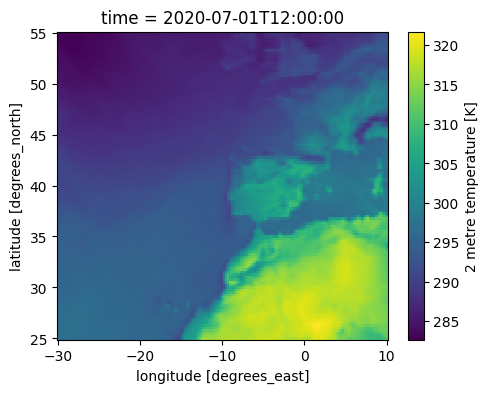

In [46]:
# Para algunas aplicaciones es preferible tener un eje de latitudes crecientes
# Por ejemplo, esta extracción de un rango de latitudes en xarray da un error
# porque en el fichero las latitudes están dispuestas de mayor a menor
# --------------------------------------------------------------------------------
# xr.open_dataset('julio.nc').t2m.isel(time=0).sel(latitude=slice(25,55)).plot()

# Con el fichero modificado funciona sin problemas
# --------------------------------------------------
xr.open_dataset('julio_invlat.nc').t2m.isel(time=0).sel(latitude=slice(25,55)).plot(size=4)

###Invalidación de datos mediante un área 'rectangular'

Para especificar una ventana delimitada por paralelos y meridianos basta con indicar las latitudes y longitudes de los contornos con el operador *masklonlatbox*

Los valores exteriores al área definida se etiquetan como no válidos

cdo    masklonlatbox: Processed 25921 values from 1 variable over 1 timestep [0.00s 223MB]


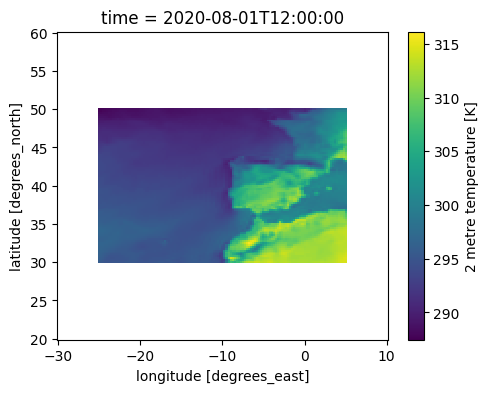

In [47]:
# Enmascaramos los datos en el exterior de la región
# Los valores se etiquetan como no válidos (missing)
# ---------------------------------------------------
!cdo -O masklonlatbox,-25,5,30,50 agosto.nc region.nc

# Datos de temperatura en el interior de la región
# --------------------------------------------------
xr.open_dataset('region.nc').t2m.isel(time=0).plot(size=4)

###Ejemplo: retención de datos mediante un área arbitraria

In [48]:
# Definimos una región indicando las coordenadas de los vértices
# ---------------------------------------------------------------
!rm -f             region.txt
!echo "-5 30"   >> region.txt
!echo "-15 40"  >> region.txt
!echo "-5 50"   >> region.txt
!echo "5 40"    >> region.txt

In [49]:
# Enmascaramos los datos en el exterior de la región
# Los valores se etiquetan como no válidos (missing)
# ---------------------------------------------------
!cdo maskregion,region.txt agosto.nc region.nc

cdo    maskregion: Processed 25921 values from 1 variable over 1 timestep [0.01s 224MB]


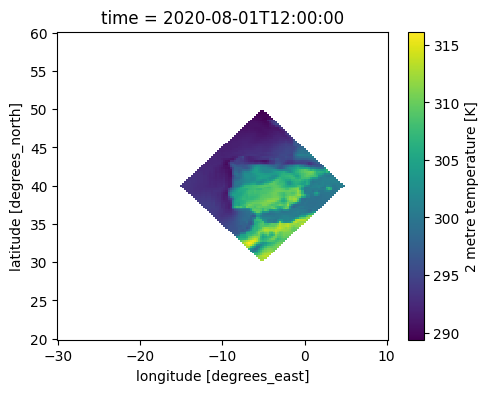

In [50]:
# Datos de temperatura en el interior de la región
# --------------------------------------------------
xr.open_dataset('region.nc').t2m.isel(time=0).plot(size=4)

###Ejemplo: invalidación de datos por valor

A veces es necesario invalidar determinados datos para que no sean tenidos en cuenta en el cómputo

cdo    setrtomiss: Processed 25921 values from 1 variable over 1 timestep [0.00s 228MB]


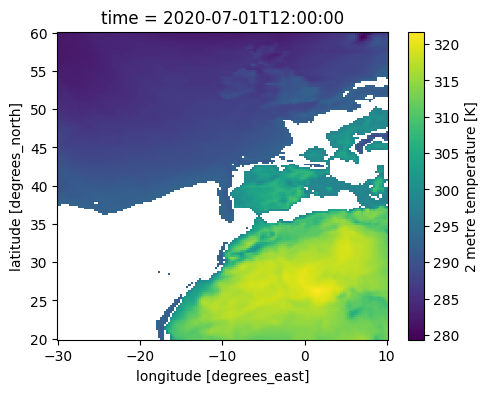

In [51]:
# Invalidamos los datos de temperatura en el rango 293-298 K (20-25ºC)
# ----------------------------------------------------------------------
!cdo setrtomiss,293,298 julio.nc  julio_sin_293-298K.nc

# Muestra el mapa sin los valores anulados
# --------------------------------------------------------------------
xr.open_dataset('julio_sin_293-298K.nc').t2m.isel(time=0).plot(size=4)

##Operadores de [aritmética](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-3370002.7)
---

Resultan extremadamente útiles los operadores que permiten calcular nuevos campos actuando sobre los existentes.

* **expr**:  evalúa expresiones aritméticas que se guardan en un nuevo fichero
* **aexpr**:  evalúa expresiones aritméticas que se anexan al fichero original


Cuando las expresiones son complicadas o involucran a varios campos puede ser más conveniente que definirlas en un script independiente. En ese caso, los operadores a utilizar son:

* **exprf**  
* **aexprf**

###Ejemplo: nuevo campo de velocidad de viento a partir de componentes vectoriales

In [52]:
!cdo seldate,'2020-12-24T12:00:00' era5_2000.nc xmas.nc
!cdo showvar xmas.nc

cdo    seldate: Processed 77763 values from 3 variables over 360 timesteps [0.02s 231MB]
 u10 v10 t2m
cdo    showname: Processed 3 variables [0.00s 231MB]


En este ejemplo el fichero de salida solo contiene el campo creado

In [53]:
# Calcula el módulo del vector de viento
# ---------------------------------------------
!cdo expr,viento='sqrt(u10*u10+v10*v10)' xmas.nc xmas_viento.nc

# Tenemos una única variable llamada 'viento'
# --------------------------------------------
!cdo showvar xmas_viento.nc

cdo    expr: Processed 51842 values from 3 variables over 1 timestep [0.01s 231MB]
 viento
cdo    showname: Processed 1 variable [0.00s 231MB]


En la versión que usa aexpr en lugar de expr el fichero de salida contiene tanto las variables antiguas como las nuevas

In [54]:
# Crea una nueva variable con el módulo del viento
# Crea una nueva variable con la temperatura en ºC
# -------------------------------------------------
!cdo -O aexpr,viento='sqrt(u10*u10+v10*v10);tc=t2m-273.15;' xmas.nc xmas_viento.nc

# Tenemos todas las variables en el nuevo fichero
# --------------------------------------------
!cdo showvar xmas_viento.nc

cdo    aexpr: Processed 77763 values from 3 variables over 1 timestep [0.01s 231MB]
 u10 v10 t2m viento tc
cdo    showname: Processed 5 variables [0.00s 231MB]


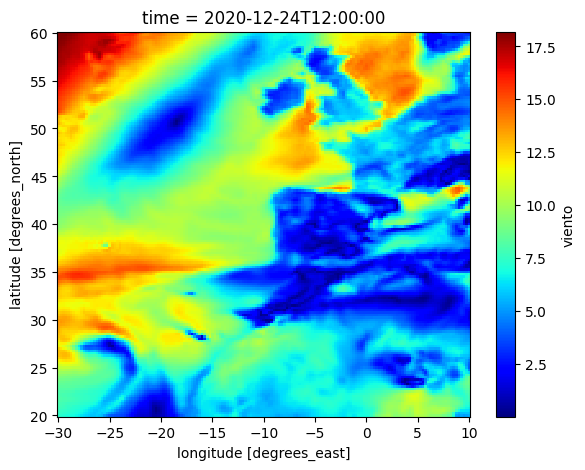

In [55]:
# Dibujamos el campo de velocidad del viento (módulo del vector) recién creado
# -----------------------------------------------------------------------------
xr.open_dataset('xmas_viento.nc').viento.isel(time=0).plot(size=5, cmap='jet')


# # ¿Añadimos los vectores al gráfico?
# # --------------------------------------
# xr.open_dataset('xmas.nc').isel(time=0).thin({'longitude':5,'latitude':5}).plot.quiver(x='longitude',y='latitude',u='u10',v='v10')


###Ejemplo: conversión de temperaturas de Kelvin a grados centígrados

Es posible aplicar operaciones aritméticas sobre los ficheros involucrando constantes. Por ejemplo, el cambio de unidades de la temperatura se puede llevar a cabo de esta otra manera:



cdo(1) selname: Process started
cdo(1) selname: Processed 25921 values from 3 variables over 1 timestep
cdo    addc: Processed 25921 values from 1 variable over 1 timestep [0.01s 237MB]


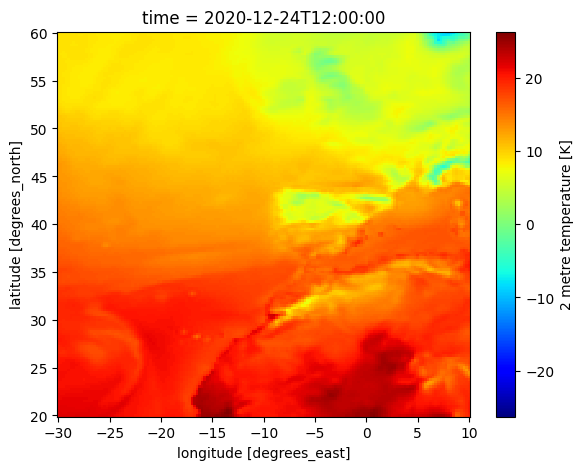

In [56]:
!cdo -b F32 -addc,-273.15 -selvar,t2m xmas.nc tc_xmas.nc

xr.open_dataset('tc_xmas.nc').t2m.isel(time=0).plot(size=5, cmap='jet')

###Ejemplo: diferencia de campos

También se pueden realizar determinadas operaciones en pares de ficheros

cdo    sub: Processed 51842 values from 2 variables over 2 timesteps [0.00s 240MB]


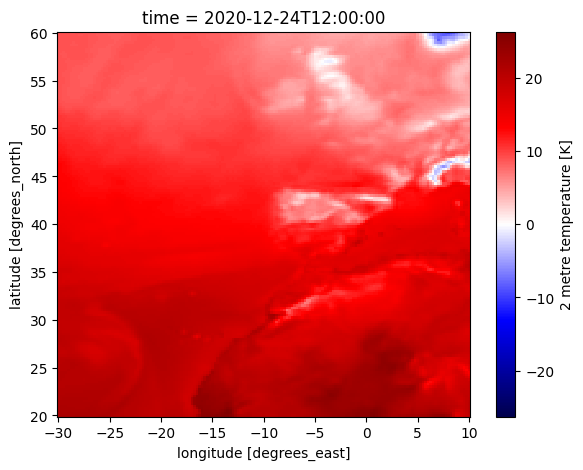

In [57]:
!cdo -b F32 sub agosto.nc julio.nc diferencia_julio_agosto.nc

xr.open_dataset('tc_xmas.nc').t2m.isel(time=0).plot(size=5, cmap='seismic')

###Ejemplo: cálculo de anomalías encadenando operadores

In [58]:
# Extrae solamente los campos de temperatura y pasa de Kelvin a ºC
# --------------------------------------------------------------------
!cdo -b F32  -addc,-273.15 -selvar,t2m  era5_2000.nc   tc.nc

# En cada punto de rejilla sustraemos el promedio mensual de temperatura
# --------------------------------------------------------------------
!cdo -b F32  -monsub tc.nc -monavg  tc.nc  tc_sin_variacion_estacional.nc


cdo(1) selname: Process started
cdo(1) selname: Processed 9487086 values from 3 variables over 366 timesteps
cdo    addc: Processed 9487086 values from 1 variable over 366 timesteps [0.25s 244MB]
cdo(1) monavg: Process started
cdo(1) monavg:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93%

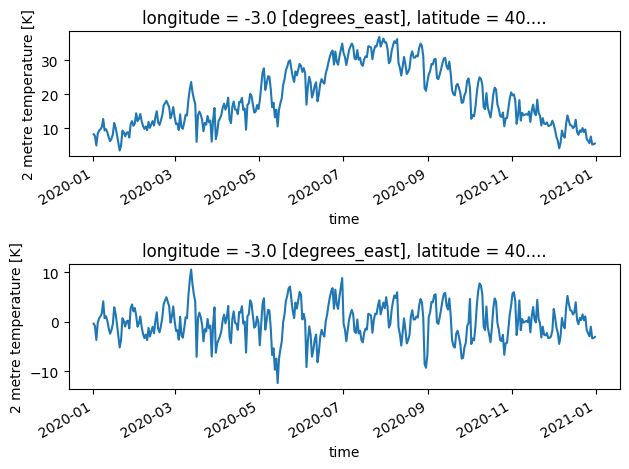

In [59]:
# Dibujamos la serie temporal de anomalías correspondiente a Madrid
# ------------------------------------------------------------------
fig,(ax1,ax2)=plt.subplots(2,1)
xr.open_dataset('tc.nc').t2m.sel(longitude=-3,latitude=40, method='nearest').plot(ax=ax1)
xr.open_dataset('tc_sin_variacion_estacional.nc').t2m.sel(longitude=-3,latitude=40, method='nearest').plot(ax=ax2)
plt.tight_layout()

###Ejemplo: añadir nuevos campos con sus atributos

In [60]:
# Escribimos las instrucciones en un fichero terminadas con punto y coma
# -----------------------------------------------------------------------
! rm -f operaciones.txt
! echo 'viento=sqrt(u10*u10+v10*v10);' >  operaciones.txt
! echo 'tc=t2m-273.15;'                >> operaciones.txt

# Realizamos las operaciones y guardamos los resultados en
# un fichero independiente. Si quisiéramos anexar las nuevas
# variables en el fichero original usaríamos el operador 'aexprf'
# ----------------------------------------------------------------
!cdo -O -setattribute,tc@info='Temperatura 2m',tc@unidades='°C',viento@info='viento a 10m',viento@unidades='m/s' -exprf,operaciones.txt xmas.nc xmas_viento.nc

cdo(1) exprf: Process started
cdo(1) exprf: Processed 77763 values from 3 variables over 1 timestep
cdo    setattribute: Processed 51842 values from 2 variables over 1 timestep [0.01s 281MB]


In [61]:
# Comprobamos el resultado
# ------------------------------
!cdo showatts xmas_viento.nc

viento:
   missing_value = -32767
   info = "viento a 10m"
   unidades = "m/s"
tc:
   missing_value = -32767
   info = "Temperatura 2m"
   unidades = "°C"
Global:
   Conventions = "CF-1.6"
   history = "Thu Jul 06 19:00:05 2023: cdo -O -setattribute,tc@info=Temperatura 2m,tc@unidades=°C,viento@info=viento a 10m,viento@unidades=m/s -exprf,operaciones.txt xmas.nc xmas_viento.nc\n"
             "Thu Jul 06 19:00:00 2023: cdo seldate,2020-12-24T12:00:00 era5_2000.nc xmas.nc\n"
             "2023-06-19 09:03:51 GMT by grib_to_netcdf-2.30.2: grib_to_netcdf era5_t2m_w10_2020_europa_025 -o era5_t2m_w10_2020_europa_025.nc"
cdo    showatts: Processed 2 variables [0.00s 281MB]


#Operadores [estadísticos](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-4040002.8)
---

Hay más de 250 operadores estadísticos en CDO.

Dos cosas importantes a tener en cuenta:

* cdo distingue entre los conceptos de 'mean' y 'average'. El primero descarta los valores no válidos (*missing*) mientras que el segundo no:

>>mean(1,2,3, missing) = 2

>>average(1,2,3, missing) = missing

>>Si no hay valores 'missing' ambas operaciones dan el mismo resultado.

* Cuando se calculan valores medios en rejillas latitud-longitud, el resultado se pondera por defecto con el área de los elementos de superficie.

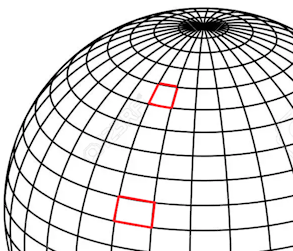


###Ejemplo: Resultados de promedios calculados con **mean** y **average**

In [62]:
# Extraemos la temperatura del día 2 de febrero de 2020
# Etiquetamos los valores comprendidos entre 273 y 300 K como inválidos (missing)
# Calculamos el valor medio con 'mean' en el dominio geográfico teniendo en cuenta las áreas de cada elemento
# Exportamos el resultado en formato tabular
# ---------------------------------------------------------------------------------------------------
!cdo -s -outputtab,date,lon,lat,value [ -fldmean   -setrtomiss,273,300  -select,name=t2m,date=2020-02-06T12:00:00 era5_2000.nc ]


# Lo mismo pero calculando el valor medio con 'average'
# -----------------------------------------------------
!cdo -s -outputtab,date,lon,lat,value [ -fldavg    -setrtomiss,273,300  -select,name=t2m,date=2020-02-06T12:00:00 era5_2000.nc ]

#      date    lon    lat    value 
 2020-02-06      0      0 299.5883 
#      date    lon    lat    value 
 2020-02-06      0      0   -32767 


# Ejemplo: medias zonales (en longitud) y meridionales (en latitud)

In [63]:
# Extraemos la temperatura del día 10 de enero de 2020
# ----------------------------------------------------
!cdo -select,name=t2m,date=2020-01-10T12:00:00 era5_2000.nc t.nc

# Calculamos la media zonal
# ------------------------------------
!cdo -zonmean t.nc media_zonal.nc

# Calculamos la media meridional
# ------------------------------------
!cdo -mermean t.nc media_meridional.nc

cdo    select: Processed 25921 values from 3 variables over 366 timesteps [0.01s 281MB]
cdo    zonmean: Processed 25921 values from 1 variable over 1 timestep [0.00s 281MB]
cdo    mermean:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%100

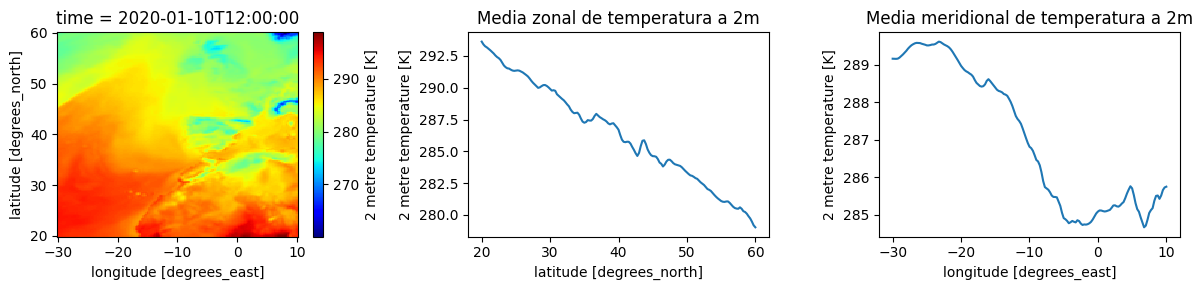

In [64]:
# Representamos gráficamente los resultados
# -------------------------------------------
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))
xr.open_dataset('t.nc').t2m.plot(ax=ax1, cmap='jet')
xr.open_dataset('media_zonal.nc').t2m.plot(ax=ax2)
xr.open_dataset('media_meridional.nc').t2m.plot(ax=ax3)
ax2.set_title('Media zonal de temperatura a 2m')
ax3.set_title('Media meridional de temperatura a 2m')
plt.tight_layout()

#Operadores de [interpolación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-6650002.12)

* Existen múltiples opciones de interpolación que benefician de la ejecución paralela.

* Los procesos de pueden optimizar guardando un fichero de pesos de interpolación

###Ejemplo: interpolaciones bilineales y bicúbicas

El fichero de temperaturas t.nc tiene una resolución espacial de 0.25º y un área limitada por los paralelos 20N y 60N y los meridianos 30W y 10E.

Para obtener una interpolación bilineal con resolución de 0.05º solo necesitamos consignar en un fichero de texto los siguientes datos:

la coordenada de partida,

* xfirst = -30
* yfirst =  10

la resolución deseada,

* xinc  = 0.05
* yinc  = 0.05

y el número de puntos de rejilla resultante en la nueva resolución,

* xsize = |lon1 - lon2| / resolución + 1 = 801
* ysize = |lat1 - lat2| / resolución + 1 = 801

Si estuviéramos interesados en un recorte xsize e ysize deberían ajustarse como corresponda.


In [65]:
!echo "gridtype  = lonlat"  >  gridfile
!echo "xsize     = 801"     >> gridfile
!echo "ysize     = 801"     >> gridfile
!echo "xfirst    = -30.0"   >> gridfile
!echo "xinc      =  0.05"    >> gridfile
!echo "yfirst    = 60.0"    >> gridfile
!echo "yinc      = -0.05"    >> gridfile

# Interpolación bilineal
# -----------------------
!cdo remapbil,gridfile t.nc t_005.nc


# # Interpolación bicúbica
# # -----------------------
# !cdo remapbic,gridfile t.nc t_005.nc

cdo    remapbil: Bilinear weights from lonlat (161x161) to lonlat (801x801) grid
cdo    remapbil:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%100%                     cdo    remapbil: Processed 

In [66]:
!echo "gridtype  = lonlat"  >  gridfile
!echo "xsize     = 4001"     >> gridfile
!echo "ysize     = 4001"     >> gridfile
!echo "xfirst    = -30.0"   >> gridfile
!echo "xinc      =  0.01"    >> gridfile
!echo "yfirst    = 60.0"    >> gridfile
!echo "yinc      = -0.01"    >> gridfile

# Interpolación bicúbica sin paralelización
# -----------------------------------------
!time cdo remapbic,gridfile t.nc t_001.nc


# Interpolación bicúbica con paralelización
# -----------------------------------------
!time cdo -P 2 remapbic,gridfile t.nc t_001.nc

cdo    remapbic: Bicubic weights from lonlat (161x161) to lonlat (4001x4001) grid
cdo    remapbic:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%100%                     cdo    remapbic: Processed

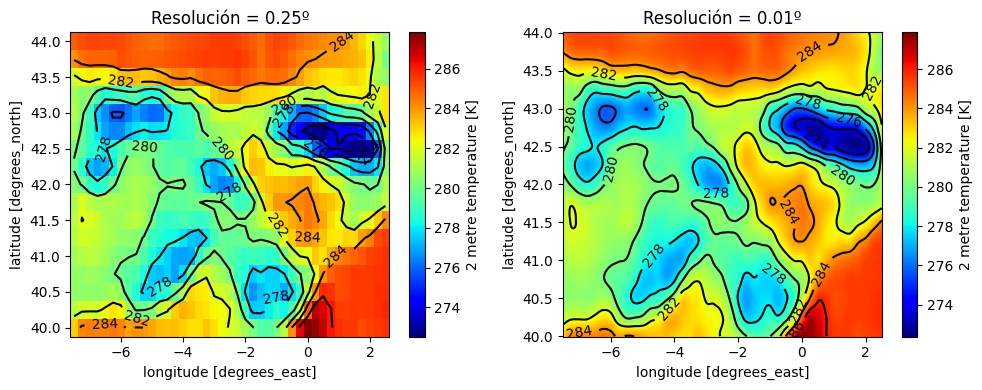

In [67]:
# Representamos gráficamente haciendo un zoom
# en una ventana para apreciar mejor los detalles
# ------------------------------------------------
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ds = xr.open_dataset('t.nc').t2m.isel(time=0).sel(longitude=slice(-7.5,2.5),latitude=slice(44,40))
ds.plot(ax=ax1, cmap='jet')
c=ds.plot.contour(ax=ax1,levels=range(270,320,2),colors='black',add_labels=True)
ax1.clabel(c,c.levels)
ax1.set_title('Resolución = 0.25º')

ds = xr.open_dataset('t_001.nc').t2m.isel(time=0).sel(lon=slice(-7.5,2.5),lat=slice(44,40))
ds.plot(ax=ax2, cmap='jet')
c = ds.plot.contour(ax=ax2,levels=range(270,320,2),colors='black',add_labels=True)
ax2.clabel(c,c.levels)
ax2.set_title('Resolución = 0.01º')

plt.tight_layout()

#Operadores de [importación / exportación](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html#x1-7980002.14)

CDO puede interactuar con otras aplicaciones con las que puede intercambiar ficheros. El formato más extendido es el ASCII.

###Ejemplo: Extracción de valores en formato ASCII

In [68]:
# Extracción de datos ASCII en 8 columnas
# -----------------------------------------
!cdo outputf,%8.4g,8 t.nc | head

     278   278.2   278.4   278.6   278.8   279.1   279.2   279.4
   279.4   279.5   279.5   279.4   279.4   279.4   279.4   279.4
   279.4   279.4   279.5   279.5   279.5   279.4   279.4   279.5
   279.6   279.7   279.7   279.8   279.8   279.9     280   280.1
   280.1   280.2   280.3   280.4   280.5   280.6   280.7   280.7
   280.8   280.8   280.8   280.9     281   281.1   281.2   281.4
   281.6   281.9   282.1   282.2   282.3   282.2   282.1   282.3
   282.5   282.7   282.9   282.9   282.8   282.7   282.5   282.4
   282.2   282.1   282.1     282     282   281.9   281.8   281.7
   281.7   281.7   281.7   281.6   281.6   281.5   281.4   281.3


In [69]:
# Selección y extracción encadenadas
# -----------------------------------
!cdo -outputf,%8.4g,8 [ -select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc ] | head

   283.6   283.7   283.8   283.9     284   284.1   284.1   284.2
   284.2   284.2   284.2   284.1   284.1   284.2   284.2   284.3
   284.3   284.3   284.3   284.3   284.3   284.3   284.3   284.3
   284.3   284.4   284.4   284.4   284.4   284.4   284.4   284.4
   284.4   284.5   284.5   284.6   284.6   284.7   284.7   284.7
   284.7   284.7   284.8   284.8   284.8   284.8   284.8   284.9
   284.9   284.9     285   285.1   285.1   285.2   285.2   285.2
   285.3   285.3   285.3   285.3   285.3   285.3   285.4   285.4
   285.4   285.5   285.5   285.5   285.5   285.5   285.6   285.6
   285.6   285.5   285.5   285.6   285.6   285.7   285.7   285.7


###Ejemplo: Extracción de datos en tabla ASCII

In [70]:
# Exportación en tabla ASCII de una selección de datos
!cdo -outputtab,name,date,day,month,year,time,lon,lat,value [ -select,name=t2m,date=2020-07-24T12:00:00 era5_2000.nc ] | head

#    name       date day month  year     time    lon    lat    value 
     t2m  2020-07-24 24  7  2020 12:00:00    -30     60 283.6473 
     t2m  2020-07-24 24  7  2020 12:00:00 -29.75     60 283.7405 
     t2m  2020-07-24 24  7  2020 12:00:00  -29.5     60 283.8298 
     t2m  2020-07-24 24  7  2020 12:00:00 -29.25     60 283.9201 
     t2m  2020-07-24 24  7  2020 12:00:00    -29     60 284.0113 
     t2m  2020-07-24 24  7  2020 12:00:00 -28.75     60 284.0927 
     t2m  2020-07-24 24  7  2020 12:00:00  -28.5     60  284.133 
     t2m  2020-07-24 24  7  2020 12:00:00 -28.25     60 284.1702 
     t2m  2020-07-24 24  7  2020 12:00:00    -28     60 284.1742 


In [71]:
# Generación de una nueva variable que se exporta en una tabla ASCII
# -------------------------------------------------------------------
!cdo -outputtab,name,date,time,lon,lat,value -expr,'viento=sqrt(u10*u10+v10*v10);' era5_2000.nc | head

#    name       date     time    lon    lat    value 
  viento  2020-01-01 12:00:00    -30     60 14.70575 
  viento  2020-01-01 12:00:00 -29.75     60 14.77884 
  viento  2020-01-01 12:00:00  -29.5     60 14.71873 
  viento  2020-01-01 12:00:00 -29.25     60 14.66887 
  viento  2020-01-01 12:00:00    -29     60 14.63494 
  viento  2020-01-01 12:00:00 -28.75     60 14.57284 
  viento  2020-01-01 12:00:00  -28.5     60 14.39617 
  viento  2020-01-01 12:00:00 -28.25     60 14.21073 
  viento  2020-01-01 12:00:00    -28     60 13.86968 


##Más herramientas

* [Acceso a datos NetCDF de Copernicus/ECMWF](https://colab.research.google.com/github/waveology/kitchen/blob/main/00_acceso_a_datos_netcdf_copernicus_ecmwf.ipynb)

* [Introducción al trabajo con NetCDF](https://colab.research.google.com/github/waveology/kitchen/blob/main/01_introduccion_al_trabajo_con_netcdf.ipynb)

* [Introducción a xarray](https://colab.research.google.com/github/waveology/kitchen/blob/main/03_introduccion_xarray.ipynb)

* [Introducción a Cartopy](https://colab.research.google.com/github/waveology/kitchen/blob/main/04_introduccion_cartopy.ipynb)

* [Introducción a Netcdf4](https://colab.research.google.com/github/waveology/kitchen/blob/main/05_introduccion_netcdf4.ipynb)

* [Introducción a nco](https://colab.research.google.com/github/waveology/kitchen/blob/main/06_introduccion_nco.ipynb)
